<a href="https://colab.research.google.com/github/Nuttapong9911/lab_05/blob/main/Hand_signs_detecting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='rgb(248, 113, 113)'>Project:</font> <font color='pink'>Hand signs detecting. ✋ </font>**

เป็นโปรเจคเกี่ยวกับการทํานายภาษามือ โดยจะให้โมเดลเรียนรู้ภาษามือหรือลักษณะของมือรูปแบบ ต่างๆ ผ่านการป้อนรูปภาพที่เป็นภาษามือรูปแบบต่างๆ เพื่อให้โมเดลสามารถ ตรวจจับและจําแนก ลักษณะท่าทางของมือได้ และ โปรเจคของกลุ่มเราสามารถนาไปใช้ต่อยอดได้ในหลายๆเรื่อง ตัวอย่าง เช่น การสร้างระบบสังการอัตโนมัติทคอยรับคําสั่งจากท่าทางของเราเพื่อทําการปิดไฟห้องเมื่อจะนอน (ไม่ต้องลุกไปปัดเอง) และน่าไปสร้างเป็นแอพพลิเคชั่น ที่สามารถช่วยให้คนปกติทั่วไปสามารถคุยกับผู้ พิการทางการได้ยินได้ง่ายขึ้น

# **Import libraries**

In [ ]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import random_split, DataLoader
# import torch.optim as optim
# import torchvision
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torchvision
from pathlib import Path

import os
from skimage import io, img_as_float

# from __future__ import print_function
import argparse
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## **Load Data From Kaggle**
Kaggle's Link: [hand-signs-images](https://www.kaggle.com/datasets/ash2703/handsignimages)

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ash2703/handsignimages

 39% 9.00M/23.1M [00:00<00:00, 77.5MB/s]
100% 23.1M/23.1M [00:00<00:00, 142MB/s] 


In [ ]:
! unzip handsignimages.zip

## **Find mean and sd of training data**

❌**no need to run again**

In [ ]:
mean_arr = np.array([])
sd_arr = np.array([])

for subdir, dirs, files in os.walk('/content/drive/MyDrive/dummy'):
    for file in files:
        # print (os.path.join(subdir, file))
        filepath = subdir + os.sep + file
        if filepath.endswith(".jpg"):
            image = io.imread(filepath)
            image = img_as_float(image)
            mean_arr = np.append(mean_arr, image)
            sd_arr = np.append(sd_arr, image)
            # print (filepath)


In [ ]:
print(len(mean_arr))
print(len(sd_arr))
print(np.mean(mean_arr))
print(np.std(sd_arr))
x = np.array([np.mean(mean_arr)])
print(len(x))
y = np.array([np.std(sd_arr)])
print(len(y))

# Find Dimension for use in Linear
❌No need to run

In [ ]:
# model1 = nn.Sequential(
#     nn.Conv2d(1, 32, kernel_size=3),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Conv2d(32, 64, kernel_size=3),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Dropout(0.25),
#     nn.Flatten(),
#     # nn.Linear(1600, 128), 
# )

# print('Dimension for fc1: ')
# model1(torch.zeros(128,1,28,28)).size()

model2 = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(0.25),
    nn.Flatten(),
    nn.Linear(1600, 128), 
    nn.ReLU(),
    nn.Dropout(0.5),
    # nn.Linear(128, 128), 
)

print('Dimension for fc2: ')
model2(torch.zeros(128,1,28,28)).size()

Dimension for fc2: 


torch.Size([128, 128])

# **Initial setting**

- <font color='yellow'>initial device setting</font>

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

- <font color='yellow'>initial parameter setting </font>

In [ ]:
args = {
    '--tain-batch-size' : 128,
    '--test-batch-size' : 128,
    '--epochs' : 15,
    '--lr' : 0.697,
    '--gamma' : 0.7,
    '--no-cuda' : True,
    '--no-mps' : True,
    '--seed' : 1
}

## **Prepare The Data**

In [ ]:
transform = torchvision.transforms.Compose([ 
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize((0.6246,), (0.1911,)),
                  torchvision.transforms.Grayscale(num_output_channels =1)
])

ds_train = torchvision.datasets.ImageFolder('/content/Train',
                                      transform=transform)

ds_test  = torchvision.datasets.ImageFolder('/content/Test',   
                                      transform=transform)
# print(len(ds_train))

ds_train, ds_val = random_split(ds_train, [21964,5491])
                                    
dl_train = DataLoader(ds_train, batch_size= args['--tain-batch-size'], shuffle=True)
dl_val   = DataLoader(ds_val, batch_size= args['--tain-batch-size'])
dl_test  = DataLoader(ds_test, batch_size= args['--test-batch-size'])

### fix bug: FileNotFoundError: Found no valid file for the classes .ipynb_checkpoints

❌ **ถ้าไม่ บัค ก็ไม่ต้องรัน**

In [ ]:
! rm -R /content/Train/.ipynb_checkpoints
! ls /content/Train 
! rm -R /content/Test/.ipynb_checkpoints
! ls /content/Test

## Testing batch size, channels, dimensions

Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


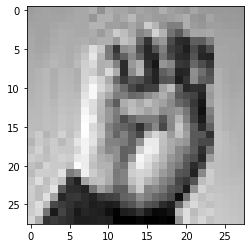

Label: 4


In [ ]:
train_features, train_labels = next(iter(dl_train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# test if data is loaded correctly
img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# **Train function**

In [ ]:
def train(args, model, device, train_loader, optimizer, epoch, loss_fn):
    trn_loss = 0.0    
    correct = 0

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      # print(f'batch_idx: {batch_idx}, data: {data}, target: {target}')
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        trn_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)          
        correct += pred.eq(target.view_as(pred)).sum().item()

    print(f'Epoch {epoch}: Train loss: {trn_loss/len(dl_train):8.5f}, Train acc: {100*correct/len(dl_train.dataset):6.2f}%')

# **Valid function**

In [ ]:
def valid(args, model, device, dl_val, loss_fn):  
  val_loss = 0.0
  val_correct = 0

  model.eval()
  val_correct = 0
  with torch.no_grad():
    for data, target in dl_val:
        data, target = data.to(device), target.to(device)

        output = model(data)                    
        loss = loss_fn(output, target)

        val_loss += loss.item()

        pred = output.argmax(dim=1, keepdim=True)  
        val_correct += pred.eq(target.view_as(pred)).sum().item()
        
    print(f'\t Valid loss: {val_loss/len(dl_val):8.5f}, Valid acc: {100*val_correct/len(dl_val.dataset):6.2f}%')

# **Test function**

In [ ]:
def test(model, device, dl_test, loss_fn):
  model.eval()
  test_correct = 0
  for data, target in dl_test:
      data, target = data.to(device), target.to(device)
      # output = nn.functional.one_hot(target, num_classes=24).float()  

      output = model(data)                        
      pred = output.argmax(dim=1, keepdim=True)  
      test_correct += pred.eq(target.view_as(pred)).sum().item() 

  print(f'\t Test acc: {100*test_correct/len(dl_test.dataset):6.2f}%')  

# **Main function**

In [ ]:
use_cuda = not args['--no-cuda'] and torch.cuda.is_available()
use_mps = not args['--no-mps'] and torch.backends.mps.is_available()

# print(f'use_cuda: {use_cuda} , use_mps: {use_mps}')

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# print(device)

model = Net().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=args['--lr'])

scheduler = StepLR(optimizer, step_size=1, gamma=args['--gamma'])
for epoch in range(1, args['--epochs'] + 1):
    train(args, model, device, dl_train, optimizer, epoch, loss_fn)
    valid(args, model, device, dl_val, loss_fn)
    test(model, device, dl_test, loss_fn)
    scheduler.step()

# if args.save_model:
#     torch.save(model.state_dict(), "mnist_cnn.pt")




Epoch 1: Train loss:  1.45255, Train acc:  56.70%
	 Valid loss:  0.29253, Valid acc:  90.69%
	 Test acc:  82.35%
Epoch 2: Train loss:  0.27352, Train acc:  90.93%
	 Valid loss:  0.04261, Valid acc:  99.54%
	 Test acc:  92.97%
Epoch 3: Train loss:  0.12836, Train acc:  95.98%
	 Valid loss:  0.01614, Valid acc:  99.80%
	 Test acc:  93.75%
Epoch 4: Train loss:  0.08105, Train acc:  97.50%
	 Valid loss:  0.00493, Valid acc: 100.00%
	 Test acc:  95.01%
Epoch 5: Train loss:  0.06203, Train acc:  98.12%
	 Valid loss:  0.00346, Valid acc: 100.00%
	 Test acc:  94.98%
Epoch 6: Train loss:  0.05083, Train acc:  98.60%
	 Valid loss:  0.00220, Valid acc: 100.00%
	 Test acc:  95.62%
Epoch 7: Train loss:  0.04705, Train acc:  98.59%
	 Valid loss:  0.00186, Valid acc: 100.00%
	 Test acc:  96.22%
Epoch 8: Train loss:  0.04230, Train acc:  98.79%
	 Valid loss:  0.00157, Valid acc: 100.00%
	 Test acc:  96.10%
Epoch 9: Train loss:  0.04068, Train acc:  98.84%
	 Valid loss:  0.00139, Valid acc: 100.00%
	 T

# **Evaluate the trained model on test data**

In [ ]:
test(model, device, dl_test, loss_fn)

	 Test acc:  95.96%


# **Reference**
- https://github.com/pytorch/examples/blob/main/mnist/main.py
- https://colab.research.google.com/drive/10W_e4U7nmN9ON4MsivRFIeHv67tH6wBL?usp=sharing&fbclid=IwAR26vlAGxuaVOXv6NfG3Aln4j-HPnHkOLzk1878rHESGd4pJtQMdI8A_sOw#scrollTo=jt_qnYd1ZO_i

# **สมาชิกในกลุ่ม**
- นายคมสัน ทรวงแก้ว ุ630610720
- นายเทวฤทธิ์ สมฤทธิ์ 630610731
- นายนัฐพงษ์ บุญสละ 630610744